In [1]:
!pip install -q finance-datareader

In [2]:
import os
import time

import pandas as pd
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy 
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def get_data(sym):
    file_path = "/content/gdrive/MyDrive/stockData/"
    csv_path = os.path.join(file_path, f"{sym}.csv")
    df = pd.read_csv(csv_path, parse_dates=True, index_col = ['Date'])
    return df

In [5]:
def Min_Max_Scaler(dataframe):
    d_min = np.min(dataframe, 0)
    d_max = np.max(dataframe, 0)

    numerator = dataframe - d_min
    denominator = d_max - d_min

    df = numerator / (denominator + 1e-7)


    return df

In [6]:
def return_data(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

In [7]:
class StockDataset(Dataset):
    
    def __init__(self, data, x_frames, y_frames, start, end):
        self.x_frames = x_frames
        self.y_frames = y_frames

        self.start = start
        self.end = end

        self.data = data.loc[self.start : self.end]


    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['Close','Open', 'High', 'Low', 'Volume', 'Change']]
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [8]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [9]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, batch_size, dropout, use_bn):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.h = self.init_hidden()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, h = self.gru(x, self.h)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_().to("cuda:0")
        return hidden

In [10]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [11]:
class EarlyStopping:
    def __init__(self, args):
        self.patience = args.patience
        self.counter = 0
        self.best_score = None
        self.best_val_acc = None
        self.best_train_acc = None
        self.val_loss_min = np.Inf
        self.early_stop = False


        self.hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

        if not os.path.isdir(args.path):
            os.mkdir(args.path)

    def __call__(self, val_loss, val_acc, train_acc, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))

            torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')
            
            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_val_acc = val_acc
            self.best_train_acc = train_acc

            self.counter = 0

            print('Validation loss decreased --- Saving model ...')
            torch.save(model.state_dict(), args.path+f'{args.exp_name}-{self.hash_key}-model.pt')
            self.val_loss_min = val_loss

In [24]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)

    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):

        X = X.to(args.device)
        y = y.to(args.device)

        X = X.transpose(0, 1).float()
        y_true = y[:, :, 0].float()
        
        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]


        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [25]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()

            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
    
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [26]:
def experiment(partition, args):
    hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)

    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice. Choose one of SGD, RMSprop, Adam')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
    
    # early_stopping = EarlyStopping(args)

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        
        start = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        end = time.time()

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch+1, train_acc, val_acc, train_loss, val_loss, end-start))

        # early_stopping(val_loss, val_acc, train_acc, model)

        # if early_stopping.early_stop:
        #     print("Early Stopping!!")
        #     val_loss = early_stopping.val_loss_min
        #     val_acc = early_stopping.best_val_acc
        #     train_acc = early_stopping.best_train_acc
        #     end = time.time()
        #     break
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #


    # model.load_state_dict(torch.load(args.path+f'{args.exp_name}-{hash_key}-model.pt'))
    

    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = [x for x in train_losses]
    result['val_losses'] = [x for x in val_losses]
    result['train_accs'] = [x for x in train_accs]
    result['val_accs'] = [x for x in val_accs]
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    
    return model, vars(args), result

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join


def save_exp_result(setting, result):
    exp_name = setting['exp_name']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    
    filepath = '/content/gdrive/MyDrive/results'
    if not os.path.isdir(filepath):
        os.mkdir(filepath)

    filename = '/content/gdrive/MyDrive/results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = '/content/gdrive/MyDrive/results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result)
    return df

In [16]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(args.device)

cuda:0


In [17]:
# ====== Data Loading ====== #
args.symbol = 'AAPL'
args.batch_size = 16
args.x_frames = 5
args.y_frames = 1

df = get_data('AAPL')
df_scaled = Min_Max_Scaler(df)

In [18]:
trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2000-01-01', '2018-01-01')
valset = StockDataset(df_scaled, args.x_frames, args.y_frames, '2018-01-01', '2019-01-01')

partition = {'train': trainset, 'val':valset}

In [19]:
# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 1

In [20]:
# ====== Regularization ======= #
args.l2 = 0.0001
args.dropout = 0.3
args.use_bn = True

In [27]:
# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 100
args.patience = 20
args.path = '/content/gdrive/MyDrive/model_checkpoint/'

In [28]:
def test(model, data, start, end, args):
    data_scaled = Min_Max_Scaler(data)

    testset = StockDataset(data_scaled, args.x_frames, args.y_frames, start, end)

    testloader = DataLoader(testset, 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    
    test_t = data.loc[start:end]
    test_ind = test_t.index
    
    d_min = np.min(data, 0)
    d_max = np.max(data, 0)

    model.eval()    

    test_acc = 0.0
    prediction = []
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.to(args.device)
            y = y.to(args.device)

            X = X.transpose(0, 1).float()
            y_true = y[:, :, 0].float()
            
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

            temp = []
            y = y_pred.cpu().detach().numpy()

            for i in range(len(y)):
                temp.append(y[i].item())

            prediction = prediction + temp


    test_acc = test_acc / len(testloader)

    len_pred = len(prediction)
    len_ind = len(test_ind)

    temp_ind = len_pred - len_ind
    ind = test_ind[:temp_ind]

    test_df = pd.DataFrame({"Close": prediction}, index=ind)
    test_df = return_data(test_df, d_min[0], d_max[0])

    true_y = data.loc[ind[0]:ind[-1]]['Close']

    return test_df, pd.DataFrame(true_y)

In [29]:
# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]

model_dict = {}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        model, setting, result = experiment(partition, deepcopy(args))
        hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
        model_dict[hash_key] = model
        save_exp_result(setting, result)

Namespace(batch_size=16, device='cuda:0', dropout=0.3, epoch=100, exp_name='exp1_lr', hid_dim=50, input_dim=6, l2=0.0001, lr=0.001, n_layers=1, optim='Adam', path='/content/gdrive/MyDrive/model_checkpoint/', patience=20, symbol='AAPL', use_bn=True, x_frames=5, y_frames=1)
Epoch 1, Acc(train/val): 5.81/2.69, Loss(train/val) 0.00570/0.00042. Took 6.50 sec
Epoch 2, Acc(train/val): 2.60/8.49, Loss(train/val) 0.00097/0.00350. Took 6.30 sec
Epoch 3, Acc(train/val): 2.30/4.57, Loss(train/val) 0.00074/0.00114. Took 6.35 sec
Epoch 4, Acc(train/val): 2.16/1.19, Loss(train/val) 0.00066/0.00011. Took 6.30 sec
Epoch 5, Acc(train/val): 1.96/5.80, Loss(train/val) 0.00056/0.00170. Took 6.43 sec
Epoch 6, Acc(train/val): 1.93/2.54, Loss(train/val) 0.00053/0.00038. Took 6.27 sec
Epoch 7, Acc(train/val): 1.80/2.15, Loss(train/val) 0.00048/0.00029. Took 6.34 sec
Epoch 8, Acc(train/val): 1.80/3.23, Loss(train/val) 0.00048/0.00059. Took 6.28 sec
Epoch 9, Acc(train/val): 1.70/3.09, Loss(train/val) 0.00042/0.0

In [ ]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])

    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')


In [ ]:
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89)

In [ ]:
var1 = 'lr'
var2 = 'n_layers'
df_result = load_exp_result('exp1')

In [ ]:
df_result = df_result[df_result['dropout']==0.3]

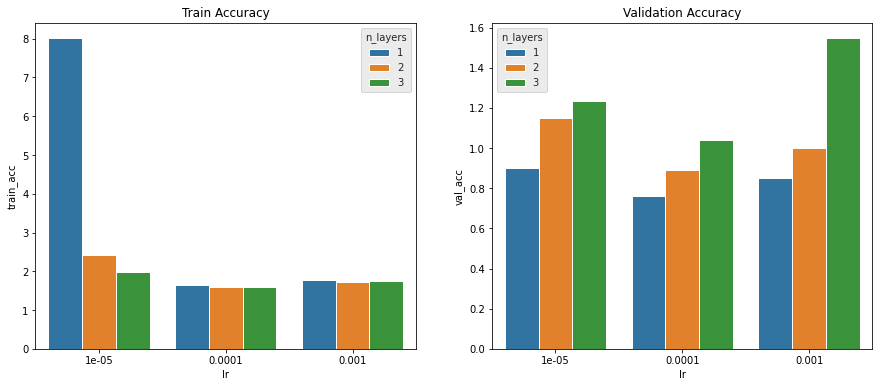

In [ ]:
plot_acc(var1, var2, df_result)

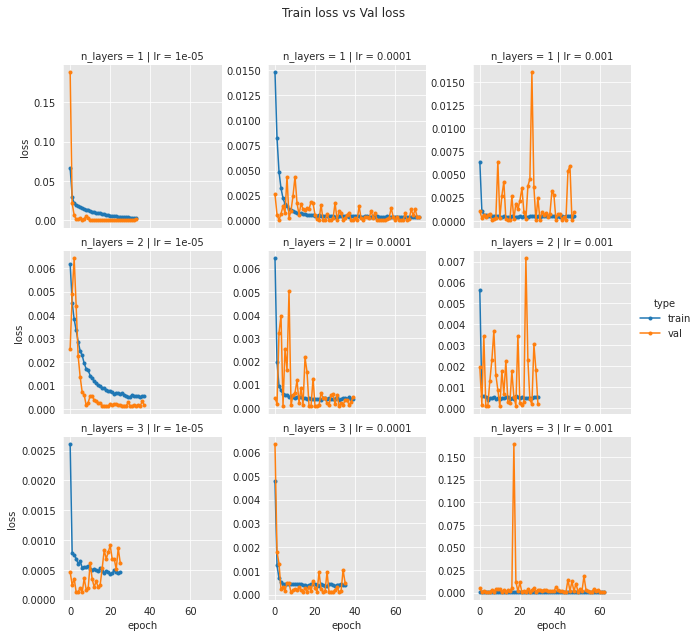

In [ ]:
plot_loss_variation(var1, var2, df_result, sharey=False)

In [ ]:
args.lr = 0.001
args.n_layers = 3

In [ ]:
hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]
hash_key

'2ee2de'

In [ ]:
model_1 = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)

model_1.load_state_dict(torch.load(args.path+f'{args.exp_name}-{hash_key}-model.pt'))

<All keys matched successfully>

In [ ]:
model_1.to(args.device)

LSTM(
  (lstm): LSTM(6, 50, num_layers=3)
  (regressor): Sequential(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [ ]:
test_y, true_y = test(model_1, df, '2020-01-01', '2020-12-24', args)

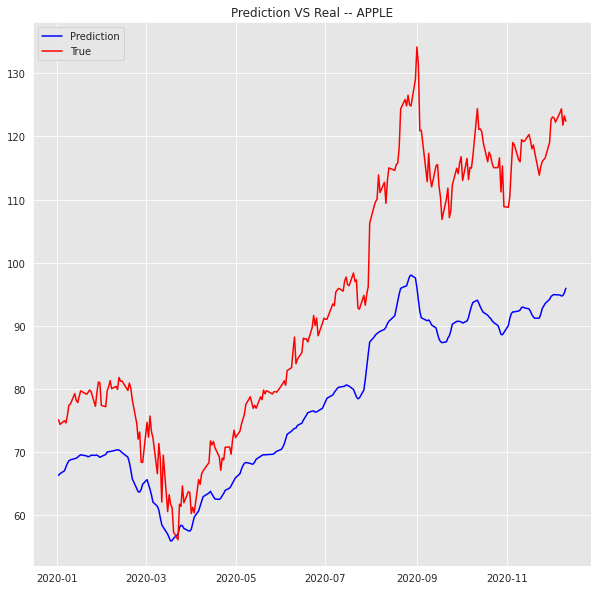

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real -- APPLE")
plt.plot(test_y, color='b')
plt.plot(true_y, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [ ]:
df2 = get_data('AMZN')
df2_scaled = Min_Max_Scaler(df2)

In [ ]:
test_y2, true_y2 = test(model_1, df2, '2020-01-01', '2020-12-24', args)

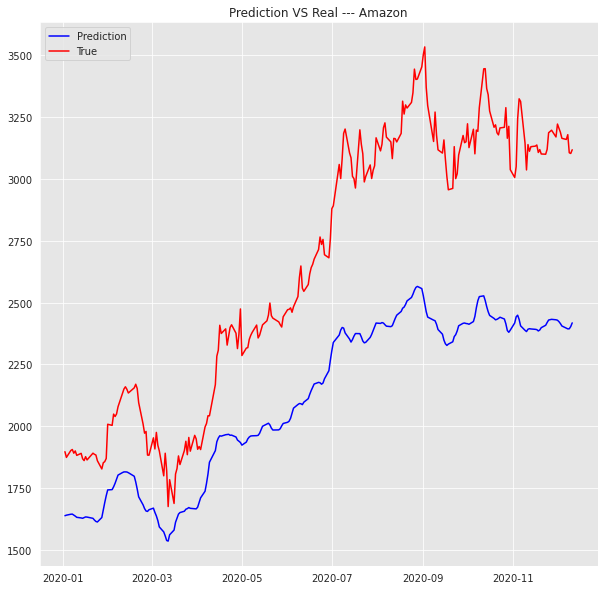

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real --- Amazon")
plt.plot(test_y2, color='b')
plt.plot(true_y2, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [ ]:
args.lr = 0.0001
args.n_layers = 1

hash_key = hashlib.sha1(str(vars(args)).encode()).hexdigest()[:6]

In [ ]:
model_2 = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)

model_2.load_state_dict(torch.load(args.path+f'{args.exp_name}-{hash_key}-model.pt'))
model_2.to(args.device)

LSTM(
  (lstm): LSTM(6, 50)
  (regressor): Sequential(
    (0): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=1, bias=True)
  )
)

In [ ]:
test_y, true_y = test(model_2, df, '2020-01-01', '2020-12-24', args)

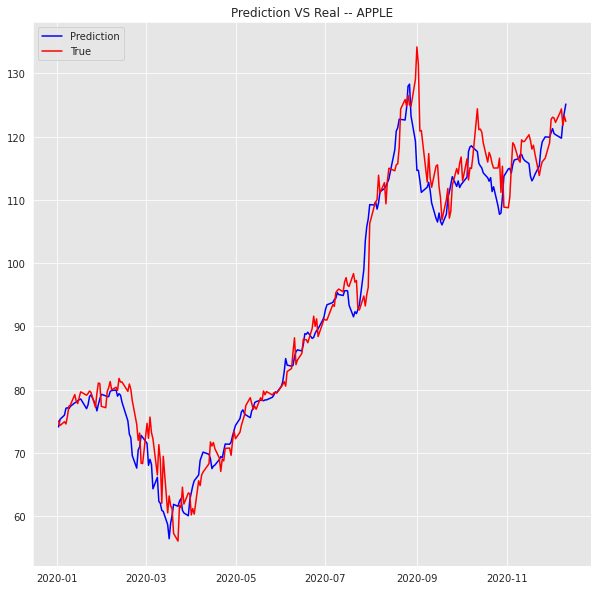

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real -- APPLE")
plt.plot(test_y, color='b')
plt.plot(true_y, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [ ]:
mean_absolute_error(test_y, true_y)

2.8669132295350206

In [ ]:
test_y2, true_y2 = test(model_2, df2, '2020-01-01', '2020-12-24', args)

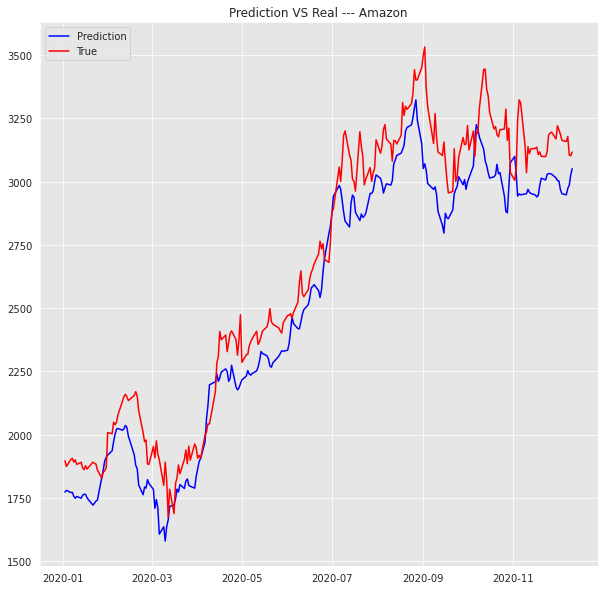

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Prediction VS Real --- Amazon")
plt.plot(test_y2, color='b')
plt.plot(true_y2, color='r')
plt.legend(["Prediction", "True"],loc='upper left')

In [ ]:
mean_absolute_error(test_y2, true_y2)

536.6237268637817

# Grid Search

# Dataset Indexing

In [ ]:
sp500 = fdr.StockListing('S&P500')
sp500_list = list(sp500['Symbol'])

In [ ]:
for name in sp500_list:
    print(name+' training start')
    args.symbol = name
    df = get_data(args.symbol)
    df_scaled = Min_Max_Scaler(df)

    split = int(len(df) * 0.8)
    split2 = int(len(df) * 0.1)

    train_start = df.index[0]
    train_end = df.index[split]

    val_start = df.index[split]
    val_end = df.index[split+split2]

    trainset = StockDataset(df_scaled, args.x_frames, args.y_frames, train_start, train_end)
    valset = StockDataset(df_scaled, args.x_frames, args.y_frames, val_start, val_end)
    print(len(trainset), len(valset))

    partition = {'train': trainset, 'val':valset}

MMM training start
4220 524
ABT training start
4220 524
ABBV training start
1616 198
ABMD training start
4218 523
ACN training start
3908 485
ATVI training start
4220 524
ADBE training start
4220 524
AMD training start
4220 524
AAP training start
3836 476
AES training start
4220 524
AFL training start
4220 524
A training start
4220 524
APD training start
4220 524
AKAM training start
4220 524
ALK training start
4220 524
ALB training start
4220 524
ARE training start
4220 524
ALXN training start
4220 524
ALGN training start
4004 497
ALLE training start
1427 174
LNT training start
4220 524
ALL training start
4220 524
GOOGL training start
3290 407
GOOG training start
1356 166
MO training start
4220 524
AMZN training start
4220 524
AMCR training start
308 35
AEE training start
4220 524
AAL training start
1416 173
AEP training start
4220 524
AXP training start
4220 524
AIG training start
4220 524
AMT training start
4220 524
AWK training start
2550 315
AMP training start
3072 380
ABC training

In [ ]:
class GRU(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(GRU, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
                          
    def forward(self, x):
        out, self.hidden = self.gru(x, self.hidden)
        y_pred = self.regressor(out[-1].view(self.batch_size, -1))
        return y_pred

NameError: ignored